In [1]:
import json
import random
import uuid
import numpy as np
import time
import requests
import traceback
import math
import ast
import pandas as pd
import pdb
from tqdm.auto import tqdm
tqdm.pandas()

# Functions

In [2]:
def convert_df_to_json_set_SINGLE(df):
    microtask_jsons = []
    padding = 100
    try:
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            for idy, evidence in enumerate(row['nlp_sentences_all_TOP_N']):
                
                # Let us retrieve the sections before and after the evidence. 100 characters to each side will do.
                all_sentences = row['nlp_sentences']    
                
                evidence_idx = evidence['sentence_id']
                if ';' in evidence_idx:
                    before_idx = int(evidence_idx.split(';')[0])-1
                    after_idx = int(evidence_idx.split(';')[1])+1
                else:                    
                    before_idx = int(evidence_idx)-1
                    after_idx = int(evidence_idx)+1
                    
                pre_evidence = []
                for i in range(before_idx,-1,-1):
                    pre_evidence.insert(0, all_sentences[i])
                    if len(' '.join(pre_evidence))>=100:
                        break
                pre_evidence = ' '.join(pre_evidence)
                
                post_evidence = []
                for i in range(after_idx,len(all_sentences)):
                    post_evidence.append(all_sentences[i])
                    if len(' '.join(post_evidence))>=100:
                        break
                post_evidence = ' '.join(post_evidence)
                
                assert ' '.join([pre_evidence, evidence['sentence'], post_evidence]).strip() in ' '.join(all_sentences)
                
                microtask_json = {
                    "claim_id": row['claim_id'],
                    "reference_id": row['reference_id'],
                    "evidence_id": idy,
                    "sentence_id": evidence_idx,
                    "score": evidence['score'],
                    "affirmation": row['final_verbalisation'],
                    "pre_evidence": pre_evidence,
                    "evidence": evidence['sentence'],
                    "post_evidence": post_evidence,
                    "reference_url": row['final_url'],
                    "g_id": -1
                }
                microtask_jsons.append(microtask_json)
                #raise ValueError
                
        return microtask_jsons
    except Exception:
        print(' '.join([pre_evidence, evidence['sentence'], post_evidence]))
        #print(pre_evidence)
        #print('--')
        #print(evidence['sentence'])
        #print('--')
        #print(post_evidence)
        print('--')
        print(' '.join(all_sentences))
        #print(row)
        #traceback.print_exc()
        #pdb.set_trace()
        raise
        
def convert_df_to_json_set_MULTIPLE(df):
    microtask_jsons = []
    padding = 100
    try:
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            evidence_list = []
            all_sentences = row['nlp_sentences']
            
            for idy, evidence in enumerate(row['nlp_sentences_all_TOP_N']):
                              
                evidence_idx = evidence['sentence_id']
                if ';' in evidence_idx:
                    before_idx = int(evidence_idx.split(';')[0])-1
                    after_idx = int(evidence_idx.split(';')[1])+1
                else:                    
                    before_idx = int(evidence_idx)-1
                    after_idx = int(evidence_idx)+1
                    
                pre_evidence = []
                for i in range(before_idx,-1,-1):
                    pre_evidence.insert(0, all_sentences[i])
                    if len(' '.join(pre_evidence))>=100:
                        break
                pre_evidence = ' '.join(pre_evidence)
                
                post_evidence = []
                for i in range(after_idx,len(all_sentences)):
                    post_evidence.append(all_sentences[i])
                    if len(' '.join(post_evidence))>=100:
                        break
                post_evidence = ' '.join(post_evidence)
                
                assert ' '.join([pre_evidence, evidence['sentence'], post_evidence]).strip() in ' '.join(all_sentences)
                
                evidence_list.append({
                    "evidence_id": idy,
                    "sentence_id": evidence_idx,
                    "score": evidence['score'],
                    "pre_evidence": pre_evidence,
                    "evidence": evidence['sentence'],
                    "post_evidence": post_evidence,
                })
            evidence_list_shuffle = random.Random(
                len(evidence_list[0]['evidence'])
            ).sample(evidence_list, len(evidence_list))    
            microtask_json = {
                "claim_id": row['claim_id'],
                "reference_id": row['reference_id'],
                "affirmation": row['final_verbalisation'],
                "reference_url": row['final_url'],
                "g_id": -1,
                "evidence_list": evidence_list_shuffle
            }
            microtask_jsons.append(microtask_json)
                
        return microtask_jsons
    except Exception:
        print(' '.join([pre_evidence, evidence['sentence'], post_evidence]))
        #print(pre_evidence)
        #print('--')
        #print(evidence['sentence'])
        #print('--')
        #print(post_evidence)
        print('--')
        print(' '.join(all_sentences))
        #print(row)
        #traceback.print_exc()
        #pdb.set_trace()
        raise

In [3]:
#maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
#maxSingleInstances_gd = 2

def getRandomTask(counter, n, non_gd_references, maxSingleInstances):
    p = [max(maxSingleInstances-c,0.00001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(non_gd_references))),
        size=n,
        replace=False,
        p=p
    )        
    task = []
    for i in indexes:
        reference = non_gd_references[i]
        task.append((reference,i))
    return task

def getRandomGoldenTask(counter, n, gd_references, maxSingleInstances_gd):    
    p = [max(maxSingleInstances_gd-c,0.00001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(gd_references))),
        size=n,
        replace=False,
        p=p
    )
    task = []
    for i in indexes:
        reference = gd_references[i]
        task.append((reference,i))
    return task

def generateTaskSet(counter, counter_gd, non_gd_references, gd_references, maxSingleInstances, maxSingleInstances_gd, n=(4,2)):
    '''
    counter = a counter which keeps track of how many times each reference was retrieved
    n = (x,y) where x = number of non_gd references and y = number of gd references
    '''
    taskSet = []
    task = getRandomTask(counter, n[0], non_gd_references, maxSingleInstances)
    taskSet += [r for (r,i) in task] # pairs reference,index are generated here, so that we can update the counter later
    task_gd = getRandomGoldenTask(counter_gd, n[1], gd_references, maxSingleInstances_gd)
    taskSet += [r for (r,i) in task_gd]
    taskSet_shuffle = random.Random(42).sample(taskSet, len(taskSet))
    return taskSet_shuffle, [i for (p,i) in task], [i for (p,i) in task_gd] # we return indices here to update counter


def generateIDdTaskSets(non_gd_references, gd_references, maxSingleInstances, maxSingleInstances_gd):
    counter = [0]*len(non_gd_references)
    counter_gd = [0]*len(gd_references)
    taskSets = []
    while (any([c < maxSingleInstances for c in counter])):
        taskSet, indexes, indexes_gd = generateTaskSet(counter, counter_gd, non_gd_references,
                                                       gd_references, maxSingleInstances, maxSingleInstances_gd)
        taskSetIDd = {
            '_id': str(uuid.uuid4()),
            'taskSet' : taskSet
        }
        taskSets.append(taskSetIDd)
        for i in indexes:
            counter[i] = counter[i] + 1
        for i in indexes_gd:
            counter_gd[i] = counter_gd[i] + 1
    return taskSets, counter, counter_gd

# Data

In [4]:
data_df = pd.read_json('../data/textual_entailment_df_2.json')
data_df = data_df.drop([c for c in data_df.columns if 'TOP_N' in c and 'all_TOP_N' not in c], axis=1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   reference_id                           409 non-null    object 
 1   claim_id                               409 non-null    object 
 2   final_verbalisation                    409 non-null    object 
 3   sampling_weight                        409 non-null    float64
 4   final_url                              409 non-null    object 
 5   netloc_agg                             409 non-null    object 
 6   nlp_sentences                          409 non-null    object 
 7   nlp_sentences_slide_2                  409 non-null    object 
 8   nlp_sentences_scores                   409 non-null    object 
 9   nlp_sentences_slide_2_scores           409 non-null    object 
 10  nlp_sentences_all_TOP_N                409 non-null    object 
 11  eviden

Estimated cost of running **single evidence (T1)** tasks for all 409 verbalisations, paying 0.5 per task is:

In [7]:
((data_df.shape[0]*5)-45)/4*5*0.5*1.2

1500.0

Whereas for the **multiple evidence (T2)** task paying $1 each, they are:

In [8]:
(data_df_trim_good.shape[0]-45)/4*5*1*1.2

546.0

For a total of 1787.5, which is ok

In [9]:
task_data = data_df

In [10]:
task_data.to_json('../data/textual_entailment_df_filtered_for_crowdsourcing.json',orient='records',indent=4)

# PILOT

If we select 20 entries that means:

- For the **single evidence** task, we will have 20\*5 = 100 subtasks
    - Taking 8 as golden data means (100-8)/4 = **23** tasks.
    - Giving \\$0.5 per task, giving them for 5 annotators, with 20\% to Amazon, means 23\*5\*0.5\*1.2 = \\$69.
- For the **multiple evidence** task, we will have 20 subtasks
    - Taking 4 as golden data means (20-4)/4 = **4** tasks.
    - Giving \\$1 per task, giving them for 5 annotators, with 20\% to Amazon, means 4\*5\*1\*1.2 = \\$24.
    
Total Pilot cost = $93

In [11]:
task_data = pd.read_json('../data/textual_entailment_df_filtered_for_crowdsourcing.json')

In [18]:
task_data_pilot= task_data.sample(20, random_state=42)
task_data_pilot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 172 to 77
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   reference_id                           20 non-null     object 
 1   claim_id                               20 non-null     object 
 2   final_verbalisation                    20 non-null     object 
 3   sampling_weight                        20 non-null     float64
 4   final_url                              20 non-null     object 
 5   netloc_agg                             20 non-null     object 
 6   nlp_sentences                          20 non-null     object 
 7   nlp_sentences_slide_2                  20 non-null     object 
 8   nlp_sentences_scores                   20 non-null     object 
 9   nlp_sentences_slide_2_scores           20 non-null     object 
 10  nlp_sentences_all_TOP_N                20 non-null     object 
 11  eviden

In [19]:
jsonsets_SINGLE_pilot = convert_df_to_json_set_SINGLE(task_data_pilot)
len(jsonsets_SINGLE_pilot), jsonsets_SINGLE_pilot[0]

  0%|          | 0/20 [00:00<?, ?it/s]

(100,
 {'claim_id': 'Q64566934$EA9C53AA-1E8D-4D0D-814E-0FB00E7AA3EE',
  'reference_id': 'c142c251fcb563f07dabef11a283b4fd171f1eb6',
  'evidence_id': 0,
  'sentence_id': '14',
  'score': 0.29895803330000004,
  'affirmation': 'Pandallur Hss is located in India.',
  'pre_evidence': 'PANDALLUR HSS was established in 1979 and it is managed by the Pvt. Aided. It is located in Rural area.',
  'evidence': 'It is located in MANJERI block of MALAPPURAM district of Kerala.',
  'post_evidence': "The school consists of Grades from 8 to 12. The school is Co-educational and it doesn't have an attached pre-primary section.",
  'reference_url': 'https://schools.org.in/malappuram/32050601215/',
  'g_id': -1})

In [14]:
jsonsets_MULTIPLE_pilot = convert_df_to_json_set_MULTIPLE(task_data_pilot)
len(jsonsets_MULTIPLE_pilot), jsonsets_MULTIPLE_pilot[10]

  0%|          | 0/20 [00:00<?, ?it/s]

(20,
 {'claim_id': 'Q100562234$6222DFB3-EC74-4C9D-B02D-BB70AFB981B9',
  'reference_id': '5e9bc44ce8b4ae04f57985660ab5f880cee53315',
  'affirmation': 'Merchant Shipping (Grain) Rules, 1953 has a citation of S.I. No. 348/1953.',
  'reference_url': 'https://www.irishstatutebook.ie/eli/1953/si/348/made/en/print',
  'g_id': -1,
  'evidence_list': [{'evidence_id': 0,
    'sentence_id': '47;48',
    'score': 0.9998652339,
    'pre_evidence': 'Advanced Search Cuardach Casta. Home Baile. Statutory Instruments Ionstraimí Reachtúla. 1953. S.I. No.',
    'evidence': '348/1953- Merchant Shipping (Grain) Rules, 1953. S.I.',
    'post_evidence': 'No. 348/1953- Merchant Shipping (Grain) Rules, 1953. View SI Amharc ar an IR. Amendments Leasuithe. S.I.'},
   {'evidence_id': 4,
    'sentence_id': '61;62',
    'score': 0.1842070073,
    'pre_evidence': "These Rules supersede all regulations made under section' 453 of the Merchant Shipping Act, 1894, before the coming into operation of these Rules which sa

## Separate Gold Standard

We now split the json sets into two, one with golden standards and one with references to be judged.

Here is we calculate an appropriate number of gold standards:
- Let X be the maximum expected number of tasks any singular worker can complete;
- Let Y be the number of gold standard references we have annotated;
- Let Z be the number of combinations of 2 gold standard references that we can take from the Y gold standard references in our gold set, regardless of pairing order, without repeating.
- Let P be the probability of a worker doing X tasks and not finding a repeated pair of golden standard references, taken from the set of Z gold standard pairs.

So we calculate:
- Z = Y*(Y-1)/2
- P = Z!/((Z^X)*(Z-X)!)

So, we set X = 15 (The mean number of tasks per worker for previous experiments has been 4, with standard deviation of 10.5, so if it follows a normal distribution, we get 85% of workers here).

According to the calculation below, we see that **Y = 45** gives us near 90% of chances of not having repeated gold standard, so that is how many gold standards we aim at annotating for each language

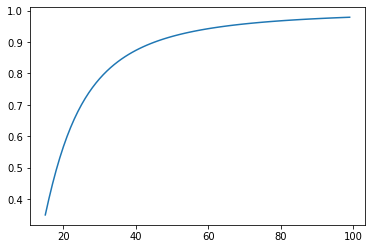

In [198]:
from decimal import Decimal
from decimal import *
import matplotlib.pyplot as plt
def fac(x):
    return Decimal(math.factorial(x))
x = 15
ys = list(range(15,100))
zs = [y*(y-1)/2 for y in ys]
ps = [fac(z)/(Decimal(z**x)*fac(z-x)) for z in zs]
plt.plot(ys,ps)

In [17]:
golden_standard_quota_SINGLE_pilot = 8 #should be 45 for the campaign
golden_standard_quota_MULTIPLE_pilot = 4

jsonsets_SINGLE_pilot_shuffle = random.Random(42).sample(jsonsets_SINGLE_pilot, len(jsonsets_SINGLE_pilot))
#with open('../data/pilot/single_gd.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_SINGLE_pilot_shuffle[:golden_standard_quota_SINGLE_pilot],
#        f, indent=2,ensure_ascii=False
#    )
with open('../data/pilot/single.json','w+',encoding='utf8') as f:
    json.dump(
        jsonsets_SINGLE_pilot_shuffle[golden_standard_quota_SINGLE_pilot:],
        f, indent=2,ensure_ascii=False
    )   
    
jsonsets_MULTIPLE_pilot_shuffle = random.Random(42).sample(jsonsets_MULTIPLE_pilot, len(jsonsets_MULTIPLE_pilot))
#with open('../data/pilot/multiple_gd.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_MULTIPLE_pilot_shuffle[:golden_standard_quota_MULTIPLE_pilot],
#        f, indent=2,ensure_ascii=False
#    )
with open('../data/pilot/multiple.json','w+',encoding='utf8') as f:
    json.dump(
        jsonsets_MULTIPLE_pilot_shuffle[golden_standard_quota_MULTIPLE_pilot:],
        f, indent=2,ensure_ascii=False
    )  

You must now annotate the golden standard by doing the following:
For each gd reference in the gd json set, go to the "gd" field, which should be like this:
```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": -1
}
```

and change it to something of the format:

```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": [list of allowed values]
}
```
where by allowed values we mean any of the following which could apply to this case:
- 0: Supports
- 1: Refutes
- 2: Neither
- 3: Not Sure

If any golden data case is ambiguous, exchange it for a non-gd case and **save to a x_gd_2.json** file

## Generating Task Sets

**Make sure you have annotated the GD before proceeding here**

**Make sure you have also filtered the non-GD for API-verifiable examples**

Now we take 4 non_gd references and 2 gd references and pack them into task sets of 6

In [21]:
cost_single_task = 0.5
maxSingleInstances = 1 #MAX TIMES ANY SUBTASK APPEARS AMONG THE TASK SETS
maxSingleInstances_gd = 6 #MAX TIMES ANY GOLDEN SUBTASK APPEARS AMONG THE TASK SETS

print('Generating Task Sets [SINGLE]')
with open('../data/pilot/single_gd.json','r',encoding='utf8') as f:
    single_gd = json.load(f)
    print('Gd len:',len(single_gd))
with open('../data/pilot/single.json','r',encoding='utf8') as f:
    single = json.load(f)
    print('Non-Gd len:',len(single))

ds, c, c_gd = generateIDdTaskSets(single, single_gd, maxSingleInstances, maxSingleInstances_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))
print()
print(f'Estimated costs: ${len(ds)*5*cost_single_task*1.2}')

with open('../data/pilot/single_TaskSets.json','w+',encoding='utf8') as f:
    json.dump(ds,f,indent=2)

Generating Task Sets [SINGLE]
Gd len: 8
Non-Gd len: 92
Generated 23 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Each golden data appearance counter is: [6, 6, 6, 6, 6, 5, 6, 5]

Estimated costs: $69.0


In [22]:
cost_single_task = 1
maxSingleInstances = 1 #MAX TIMES ANY SUBTASK APPEARS AMONG THE TASK SETS
maxSingleInstances_gd = 2 #MAX TIMES ANY GOLDEN SUBTASK APPEARS AMONG THE TASK SETS


print('Generating Task Sets [MULTIPLE]')
with open('../data/pilot/multiple_gd.json','r',encoding='utf8') as f:
    verbalisations_gd = json.load(f)
    print('Gd len:',len(verbalisations_gd))
with open('../data/pilot/multiple.json','r',encoding='utf8') as f:
    verbalisations = json.load(f)
    print('Non-Gd len:',len(verbalisations))

ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd, maxSingleInstances, maxSingleInstances_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))
print()
print(f'Estimated costs: ${len(ds)*5*cost_single_task*1.2}')

with open('../data/pilot/multiple_TaskSets.json','w+',encoding='utf8') as f:
    json.dump(ds,f,indent=2)

Generating Task Sets [MULTIPLE]
Gd len: 4
Non-Gd len: 16
Generated 4 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Each golden data appearance counter is: [2, 2, 2, 2]

Estimated costs: $24.0


In [281]:
f'Total cost is ${69+24}'

'Total cost is $93'

# CAMPAIGN

In [22]:
task_data = pd.read_json('../data/textual_entailment_df_filtered_for_crowdsourcing.json')
task_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   reference_id                           409 non-null    object 
 1   claim_id                               409 non-null    object 
 2   final_verbalisation                    409 non-null    object 
 3   sampling_weight                        409 non-null    float64
 4   final_url                              409 non-null    object 
 5   netloc_agg                             409 non-null    object 
 6   nlp_sentences                          409 non-null    object 
 7   nlp_sentences_slide_2                  409 non-null    object 
 8   nlp_sentences_scores                   409 non-null    object 
 9   nlp_sentences_slide_2_scores           409 non-null    object 
 10  nlp_sentences_all_TOP_N                409 non-null    object 
 11  eviden

In [23]:
jsonsets_SINGLE = convert_df_to_json_set_SINGLE(task_data)
len(jsonsets_SINGLE), jsonsets_SINGLE[0]

  0%|          | 0/409 [00:00<?, ?it/s]

(2045,
 {'claim_id': 'Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01',
  'reference_id': '390d6c6e68a32e11f8d7b0883cda0557db529fe6',
  'evidence_id': 0,
  'sentence_id': '28;29',
  'score': 0.9999055862,
  'affirmation': 'G V Raja died in Kullu Valley.',
  'pre_evidence': 'G.V Raja was also the President of Tourism Promotion Council of Kerala. He was the main architect in developing Kovalam as an international tourist spot.',
  'evidence': 'He died in an air crash near Kullu (Kulu) Valley on April 30, 1971. Sports journalists, historians, experts and sportsmen consider him as the Father of Sports and Tourism in Kerala.',
  'post_evidence': 'G.V Raja\'s birth anniversary, 13 October, is observed as "Kerala Sports Day". Contents. 1 Background and early life.',
  'reference_url': 'https://en.wikipedia.org/w/index.php?title=G._V._Raja&oldid=916789538',
  'g_id': -1})

In [25]:
jsonsets_MULTIPLE = convert_df_to_json_set_MULTIPLE(task_data)
len(jsonsets_MULTIPLE), jsonsets_MULTIPLE[10]

  0%|          | 0/409 [00:00<?, ?it/s]

(409,
 {'claim_id': 'Q73936275$1037AE55-B90E-44EB-8E23-76C390E0C787',
  'reference_id': '16e1d8bbc347e2506ac55ef4105c7922a81015ba',
  'affirmation': 'MOG Music began work in 2013.',
  'reference_url': 'https://en.wikipedia.org/w/index.php?title=MOG_Music&oldid=930246276',
  'g_id': -1,
  'evidence_list': [{'evidence_id': 1,
    'sentence_id': '15;16',
    'score': -0.3574801385,
    'pre_evidence': 'Singer, songwriter Years active 2013–present Associated acts. Joe Mettle. Ohemaa Mercy. Denzel Prempeh. Nii Okai. Musical artist.',
    'evidence': 'Nana Yaw Boakye better known by his stage name MOG Music is a Ghanaian contemporary gospel singer, songwriter and a pastor. Contents. 1 Music career.',
    'post_evidence': '2 Discography. 2.1 Live albums. 3 Awards and nomination. 4 References. Music career. MOG Music released his first album in 2016 "New Wine" which earned him African Gospel Music awards Nominations for "Album of the Year" and "Discovery of the Year".'},
   {'evidence_id': 4,


## Generating Artificial Golden Data

Not needed for this (for now), but let's keep the code here junst in case
```
data_df_remaining = data_df[data_df.campaign_group >= 3].reset_index(drop=True)
#Taken from not campaigns groups 0,1 and 2
```

### Generate 45 golden data points with poor fluency

Select these apart and then manually alter them

```
jsonsets = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=42).reset_index(drop=True))

for jsonset in jsonsets:
    jsonset['g_id'] = {
      "fluency": [0,1,2],
      "adequacy": [0,1,2]
    }  
    jsonset['claim_id'] = jsonset['claim_id'] '_GD_PLUS_FLUENCY'
    jsonset['verbalised_claim'] = jsonset['verbalised_claim'] + ' $ALTER THIS'
    
with open('data/campaign/batch_1/verbalisations_gd_plus_fluency.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)
```

### Generate 45 golden data points with poor adequacy

Triples are paired with random verbalisations from other triples

```
jsonsets = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=24783).reset_index(drop=True))
jsonsets_2 = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=1847).reset_index(drop=True))

for i, jsonset in enumerate(jsonsets):
    jsonset['g_id'] = {
      "fluency": [0,1,2,3,4,5],
      "adequacy": [1,2]
    }  
    
    jsonset['claim_id'] = jsonset['claim_id'] '_GD_PLUS_ADEQUACY'    
    jsonset['verbalised_claim'] = jsonsets_2[i]['verbalised_claim']

with open('data/campaign/batch_1/verbalisations_gd_plus_adequacy.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)
```

## We are first converting campaign batch 1! That is campaign groups 0, 1, and 2

In [26]:
golden_standard_quota_SINGLE = 45 #should be 45 for the campaign
golden_standard_quota_MULTIPLE = 45

jsonsets_SINGLE_shuffle = random.Random(42).sample(jsonsets_SINGLE, len(jsonsets_SINGLE))
#with open('../data/campaign/single_gd.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_SINGLE_shuffle[:golden_standard_quota_SINGLE],
#        f, indent=2,ensure_ascii=False
#    )
#with open('../data/campaign/single.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_SINGLE_shuffle[golden_standard_quota_SINGLE:],
#        f, indent=2,ensure_ascii=False
#    )   
    
jsonsets_MULTIPLE_shuffle = random.Random(42).sample(jsonsets_MULTIPLE, len(jsonsets_MULTIPLE))
#with open('../data/campaign/multiple_gd.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_MULTIPLE_shuffle[:golden_standard_quota_MULTIPLE],
#        f, indent=2,ensure_ascii=False
#    )
#with open('../data/campaign/multiple.json','w+',encoding='utf8') as f:
#    json.dump(
#        jsonsets_MULTIPLE_shuffle[golden_standard_quota_MULTIPLE:],
#        f, indent=2,ensure_ascii=False
#    )  

You must now annotate the golden standard by doing the following:
For each gd reference in the gd json set, go to the "gd" field, which should be like this:
```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": -1
}
```

and change it to something of the format:

```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": [list of allowed values]
}
```
where by allowed values we mean any of the following which could apply to this case:
- 0: Supports
- 1: Refutes
- 2: Neither
- 3: Not Sure

If any golden data case is ambiguous, exchange it for a non-gd case and **save to a x_gd_2.json** file

## Generating Task Sets

**Make sure you have annotated the GD before proceeding here**

**Make sure you have also filtered the non-GD for API-verifiable examples**

Now we take 4 non_gd references and 2 gd references and pack them into task sets of 6

In [37]:
cost_single_task = 0.5
maxSingleInstances = 1 #MAX TIMES ANY SUBTASK APPEARS AMONG THE TASK SETS
maxSingleInstances_gd = 22 #MAX TIMES ANY GOLDEN SUBTASK APPEARS AMONG THE TASK SETS

print('Generating Task Sets [SINGLE]')
with open('../data/campaign/single_gd.json','r',encoding='utf8') as f:
    single_gd = json.load(f)
    print('Gd len:',len(single_gd))
with open('../data/campaign/single.json','r',encoding='utf8') as f:
    single = json.load(f)
    print('Non-Gd len:',len(single))

ds, c, c_gd = generateIDdTaskSets(single, single_gd, maxSingleInstances, maxSingleInstances_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))
print()
print(f'Estimated costs: ${len(ds)*5*cost_single_task*1.2}')

with open('../data/campaign/single_TaskSets.json','w+',encoding='utf8') as f:
    json.dump(ds,f,indent=2)

Generating Task Sets [SINGLE]
Gd len: 45
Non-Gd len: 2000
Generated 500 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [40]:
cost_multiple_task = 1
maxSingleInstances = 1 #MAX TIMES ANY SUBTASK APPEARS AMONG THE TASK SETS
maxSingleInstances_gd = 4 #MAX TIMES ANY GOLDEN SUBTASK APPEARS AMONG THE TASK SETS


print('Generating Task Sets [MULTIPLE]')
with open('../data/campaign/multiple_gd.json','r',encoding='utf8') as f:
    verbalisations_gd = json.load(f)
    print('Gd len:',len(verbalisations_gd))
with open('../data/campaign/multiple.json','r',encoding='utf8') as f:
    verbalisations = json.load(f)
    print('Non-Gd len:',len(verbalisations))

ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd, maxSingleInstances, maxSingleInstances_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))
print()
print(f'Estimated costs: ${len(ds)*5*cost_multiple_task*1.2}')

with open('../data/campaign/multiple_TaskSets.json','w+',encoding='utf8') as f:
    json.dump(ds,f,indent=2)

Generating Task Sets [MULTIPLE]
Gd len: 45
Non-Gd len: 364
Generated 91 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [41]:
f'Total cost is ${1500+546}'

'Total cost is $2046'